In [1]:
%load_ext autoreload
%autoreload 2

# load environment variables
import os
from dotenv import load_dotenv, find_dotenv
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

from src.functions.io import ModuleFileReader
from src import queries
scripts = ModuleFileReader(queries)

In [2]:
engine = create_engine(os.environ.get("DATABASE_URL"))

## Calculate opening weekends

In [3]:
## join financial summary with opening_weekend

mojo_ts = pd.read_sql_query(scripts.read("mojo_ts.sql"), engine)

In [4]:
mojo_ts.head()

,film_id,title,budget,domestic_gross,foreign_gross,domestic_pct,foreign_pct,total_gross,roi,opening_weekend,num_theatres,window,genre
0,1,Insidious: The Last Key,10000000.0,67745330.0,100140258.0,0.403521,0.596479,167885588.0,15.788559,29581355,3116.0,56,Thriller
1,1,Insidious: The Last Key,10000000.0,67745330.0,100140258.0,0.403521,0.596479,167885588.0,15.788559,29581355,3116.0,56,Mystery
2,1,Insidious: The Last Key,10000000.0,67745330.0,100140258.0,0.403521,0.596479,167885588.0,15.788559,29581355,3116.0,56,Horror
3,5,The Commuter,40000000.0,36343858.0,83598529.0,0.180905,0.416120,200900000.0,4.022500,13701452,2892.0,63,Thriller
4,5,The Commuter,40000000.0,36343858.0,83598529.0,0.180905,0.416120,200900000.0,4.022500,13701452,2892.0,63,Mystery


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88de8fbef0>,
      dtype=object)

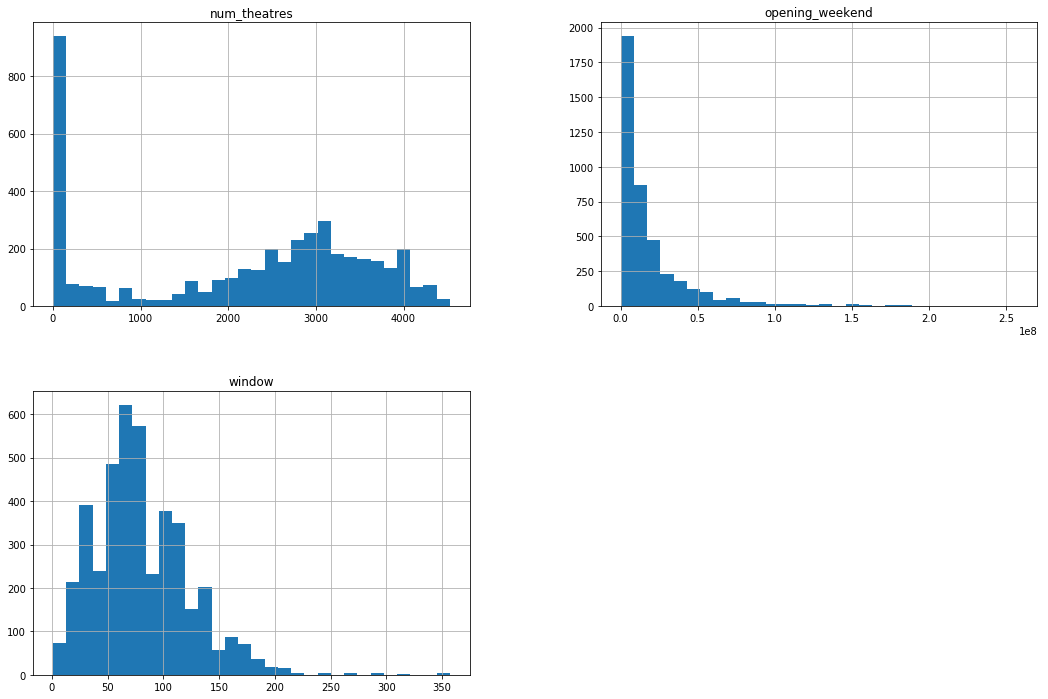

In [5]:
mojo_ts[['opening_weekend', 'num_theatres', 'window']].hist(figsize=(18,12), bins=30)

- num theatres is somewhat close to a normal distribution around 3000 theatres domestic
- opening weekend has a heavy positive skew 
- window might be poisson distributed?

In [6]:
film_ts = mojo_ts.groupby('title').mean()

(array([0.0e+00, 5.0e+07, 1.0e+08, 1.5e+08, 2.0e+08, 2.5e+08, 3.0e+08]),
 <a list of 7 Text xticklabel objects>)

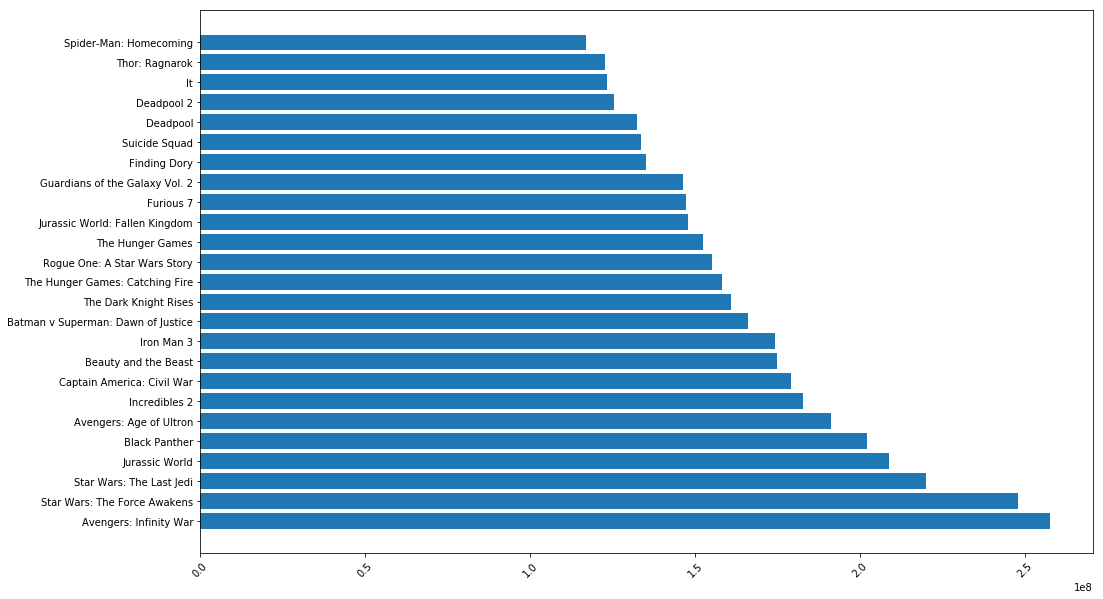

In [7]:
plt.figure(figsize=(16,10))
highest_opening_weekends = film_ts.sort_values(by="opening_weekend", ascending=False)
plt.barh(highest_opening_weekends[:25].index, highest_opening_weekends[:25].opening_weekend)
plt.xticks(rotation=45)

- Biggest opening weekends are unsurprisingly huge blockbuster films (Avengers, Star Wars)
- **It**, a horror film, making the top 25 is pretty significant. Closest thing to being a horror blockbuster I suppose

In [8]:
film_ts[film_ts.index == 'It']

,film_id,budget,domestic_gross,foreign_gross,domestic_pct,foreign_pct,total_gross,roi,opening_weekend,num_theatres,window
title,,,,,,,,,,,
It,456.0,35000000.0,327481748.0,372900000.0,0.467564,0.53241,700400000.0,19.011429,123425582.0,2554.2,98.0


- Grossing \\$700 million on a \\$35 million budget is pretty amazing, ROI of 19

In [9]:
film_ts[film_ts.index == 'Avengers: Infinity War']

,film_id,budget,domestic_gross,foreign_gross,domestic_pct,foreign_pct,total_gross,roi,opening_weekend,num_theatres,window
title,,,,,,,,,,,
Avengers: Infinity War,90.0,400000000.0,678815482.0,1.369544e+09,0.331395,0.668605,2.048360e+09,4.120899,257698183.0,4474.0,140.0


- Infinity War, the highest grossing film, only has a ROI of 4.12. \\$257 million opening weekend pretty amazing

Looking at the domestic opening weekend as a percentage of a film's total domestic_gross

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 <a list of 7 Text xticklabel objects>)

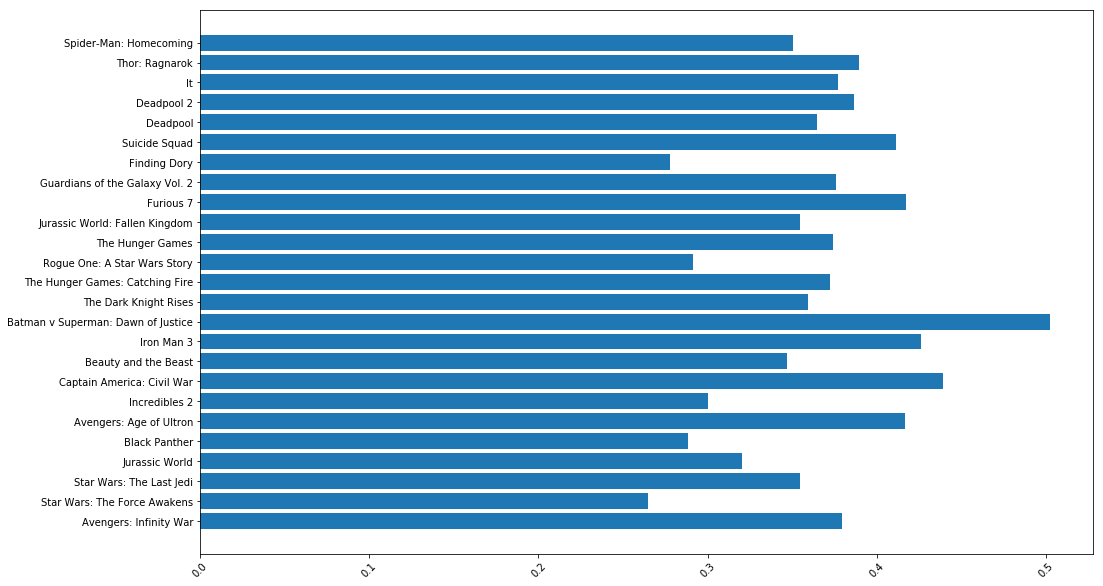

In [10]:
film_ts['pct_of_domestic_gross'] = film_ts.opening_weekend/film_ts.domestic_gross
highest_opening_weekends = film_ts.sort_values(by="opening_weekend", ascending=False)

plt.figure(figsize=(16,10))
plt.barh(highest_opening_weekends[:25].index, highest_opening_weekends[:25].pct_of_domestic_gross)
plt.xticks(rotation=45)

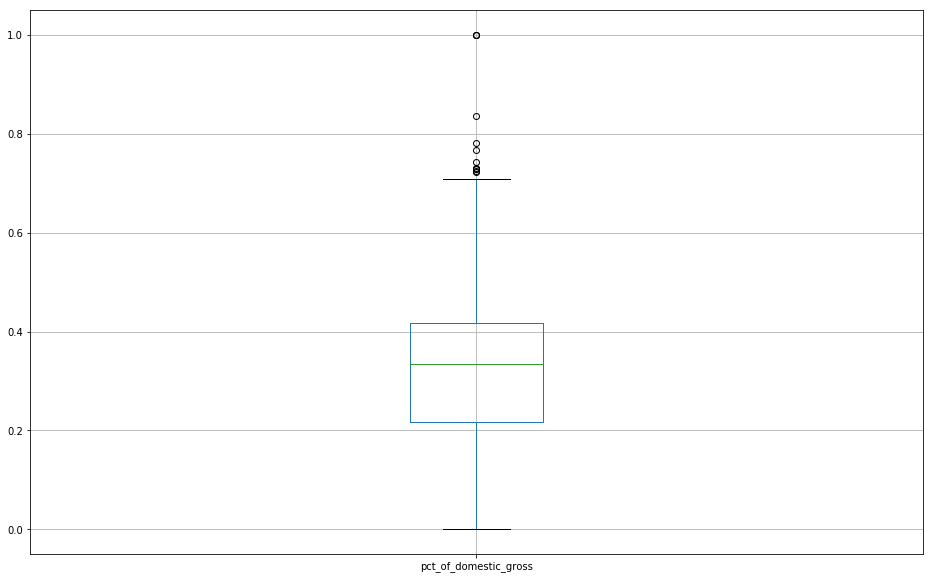

In [11]:
plt.figure(figsize=(16,10))
film_ts.boxplot("pct_of_domestic_gross")

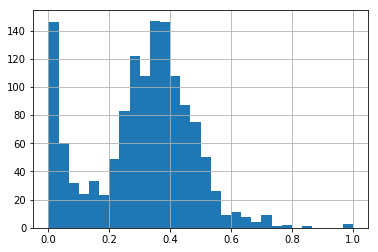

In [12]:
film_ts.pct_of_domestic_gross.hist(bins=30)

- Most films seem to make approximately 20-40% of their total domestic gross in the opening weekend
- About a third of all the moviegoers who are going to see a see a film catch it in the first weekend
- By extension, could multiplying a film's opening weekend by 3 give us a good indication of its total domestic gross?

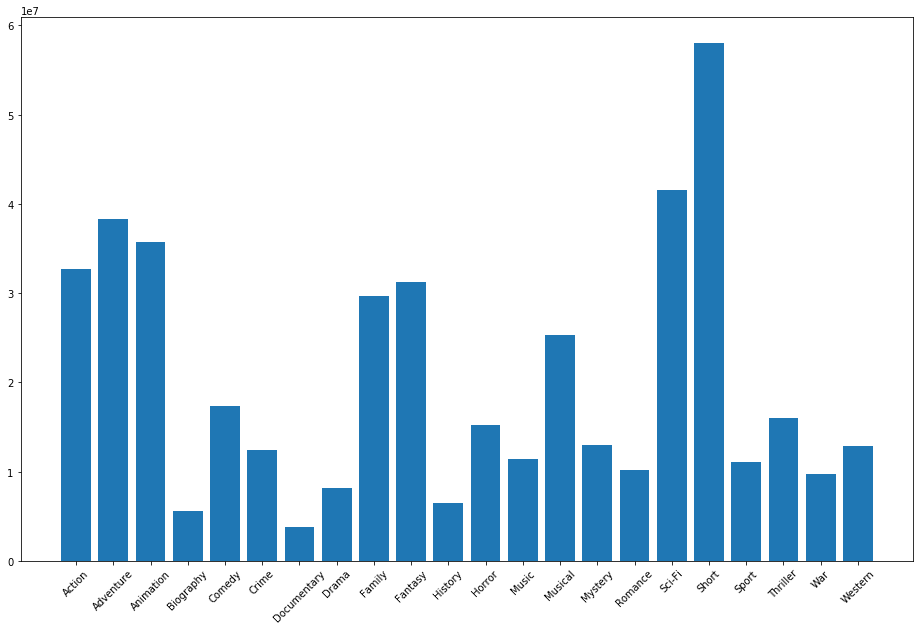

In [13]:
genre_avg_opening = mojo_ts.groupby('genre').mean().opening_weekend
plt.figure(figsize=(16,10))
plt.bar(genre_avg_opening.index, genre_avg_opening.values)
plt.xticks(rotation=45)
plt.show()

In [14]:
genre_avg_opening.median()

14120199.522345787

In [15]:
genre_avg_opening['Horror']

15236133.013245033

- Why is short so high up here?
- Everything else makes enough sense, horror is on the lower side
- All the blockbuster genres have predictably high numbers

- Avg. Horror openings are slightly below avg for all genres but slightly above median. Blockbusters skew the data

In [16]:
mojo_ts[mojo_ts.genre == 'Short']

,film_id,title,budget,domestic_gross,foreign_gross,domestic_pct,foreign_pct,total_gross,roi,opening_weekend,num_theatres,window,genre
697,352,Your Name.,NaN,5017246.0,352968841.0,0.014015,0.985946,3.580000e+08,NaN,1816600,235.25,112,Short
1075,529,Star Wars: The Last Jedi,225000000.0,620181382.0,712358507.0,0.465413,0.534587,1.332540e+09,4.922400,220009584,4232.00,126,Short
2057,1135,Prem Ratan Dhan Payo,NaN,4364639.0,48192185.0,0.083046,0.916954,5.255682e+07,NaN,2425585,287.00,11,Short
2940,1698,The Counselor,25000000.0,16973715.0,54035619.0,0.239035,0.760965,7.100933e+07,1.840373,7842930,3044.00,70,Short


- Not sure how Last Jedi became a short film lol. Or even Your Name, for that matter.
- The short genre could just be dropped overall, pretty useless

Let's check % of total domestic for each genre's opening weekend

In [17]:
mojo_ts['pct_of_domestic'] = mojo_ts.opening_weekend/mojo_ts.domestic_gross

In [18]:
genre_mean = mojo_ts.groupby('genre').mean()
genre_std = mojo_ts.groupby('genre').std()

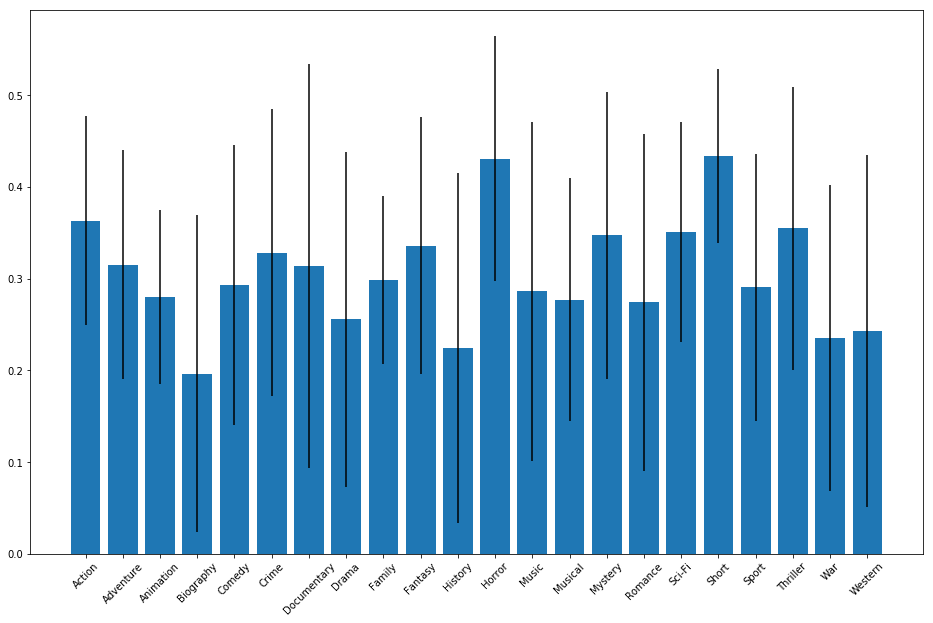

In [19]:
plt.figure(figsize=(16,10))
yerr = mojo_ts.groupby('genre').std()['pct_of_domestic']
plt.bar(genre_mean.index, genre_mean.pct_of_domestic, yerr=genre_std.pct_of_domestic)
plt.xticks(rotation=45)
plt.show()

- Out of all genres, horror makes the most of its total domestic gross in the opening weekend...
- This suggests that horror movies might not have as long of legs? Check window and see.
- Horror might need to have a bigger push for opening weekends then

In [27]:
genre_mean.pct_of_domestic

genre
Action         0.363295
Adventure      0.315118
Animation      0.280220
Biography      0.196198
Comedy         0.293500
Crime          0.328436
Documentary    0.313816
Drama          0.255537
Family         0.298546
Fantasy        0.335676
History        0.224284
Horror         0.430809
Music          0.285989
Musical        0.277145
Mystery        0.346993
Romance        0.274037
Sci-Fi         0.350735
Short          0.433655
Sport          0.290418
Thriller       0.354843
War            0.235260
Western        0.242873
Name: pct_of_domestic, dtype: float64

## Window

- Should condense many of the SQL queries into just a big timeseries table with all the summary stats

In [20]:
film_ts.window.mean()

76.97456395348837

In [21]:
film_ts.window.std()

41.515649708499275

Most films have a window of 2.5 months, with standard deviation about a month

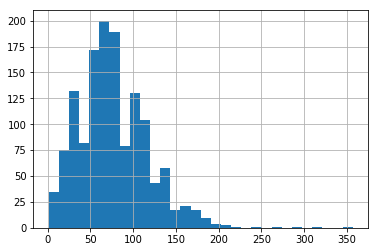

In [22]:
film_ts.window.hist(bins=30)

<BarContainer object of 25 artists>

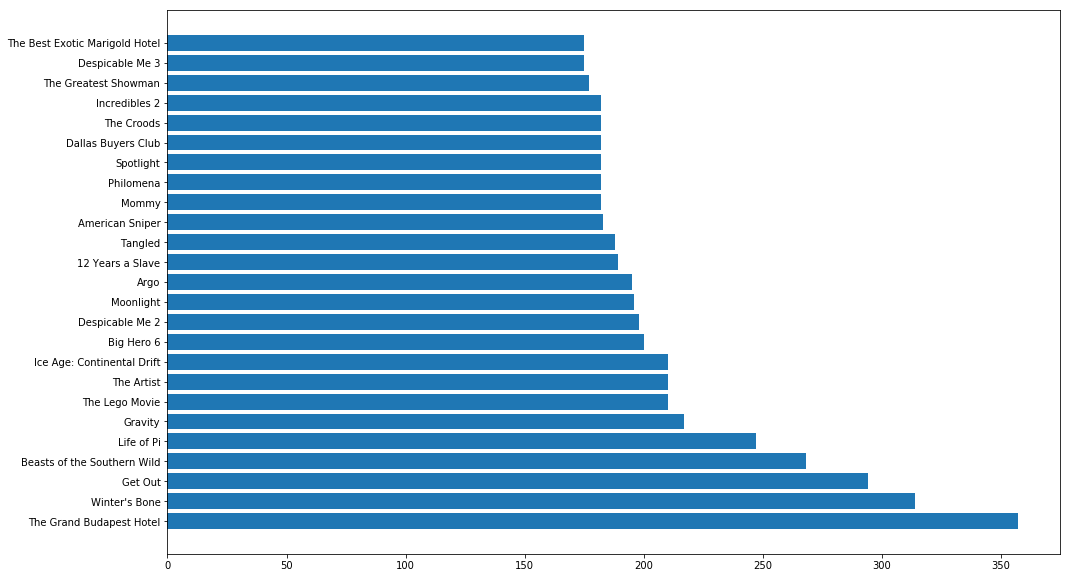

In [23]:
longest_windows = film_ts.sort_values(by='window', ascending=False)
plt.figure(figsize=(16,10))
plt.barh(longest_windows[:25].index, longest_windows[:25].window)

- Nothing you would really expect for longest window
- Most of these films get rereleased in theatres if they get award buzz

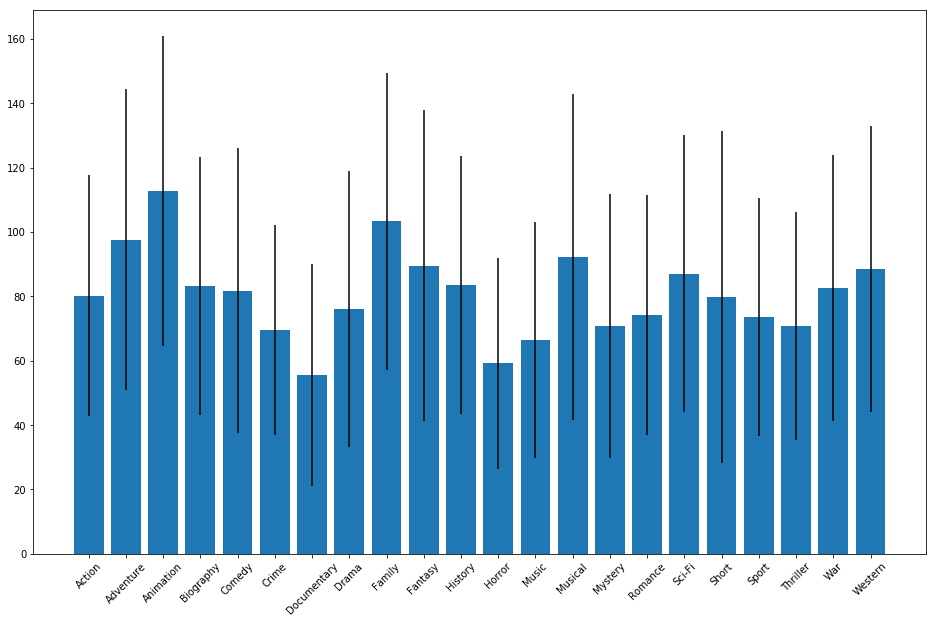

In [24]:
plt.figure(figsize=(16,10))
plt.bar(genre_mean.index, genre_mean.window, yerr=genre_std.window)
plt.xticks(rotation=45)
plt.show()

- Horror movies don't have long legs, they actually only last about two months in theatres. Slightly below avg

In [25]:
genre_mean.window['Horror']

59.18543046357616

In [26]:
differen kinds of joins, aggregate, window functions, parsing data, filtering data

SyntaxError: invalid syntax (<ipython-input-26-7dbba61cc4fe>, line 1)